# Looking at Extra features: 

Using the forecasted generation mix from carbonintensity.org, we have access to predictions on the proportions of different fuel types used over specific time frames. The fuels include a mix of fossil fuels—such as gas and coal—alongside nuclear, wind, and solar energy.

Since this data is forecasted and generated days in advance, we can leverage it for next-day predictions without significant concerns about data leakage. This makes it reasonable to incorporate these forecasts into our model.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt


data_df = pd.read_csv('../data/generation_data.csv', index_col=0)
data_df.index.name = "Data"

# set to datetime
data_df.index = pd.to_datetime(data_df.index)
data_df.index = data_df.index.tz_localize(None) # Remove timezone
data_df.head(5)

,biomass,coal,imports,gas,nuclear,other,hydro,solar,wind
Data,,,,,,,,,
2022-01-01 00:00:00,5.9,0.0,5.6,10.6,26.4,0,1.2,0.0,50.3
2022-01-01 00:30:00,6.0,0.0,5.8,11.1,26.5,0,1.1,0.0,49.5
2022-01-01 01:00:00,5.9,0.0,5.0,11.3,26.1,0,1.0,0.0,50.6
2022-01-01 01:30:00,5.7,0.0,5.0,10.8,25.6,0,1.0,0.0,51.9
2022-01-01 02:00:00,5.9,0.0,2.7,10.4,26.3,0,1.0,0.0,53.6


We can notice the data are the percent usage during that time period. 

Lets plot variations over the first day of febuary: 

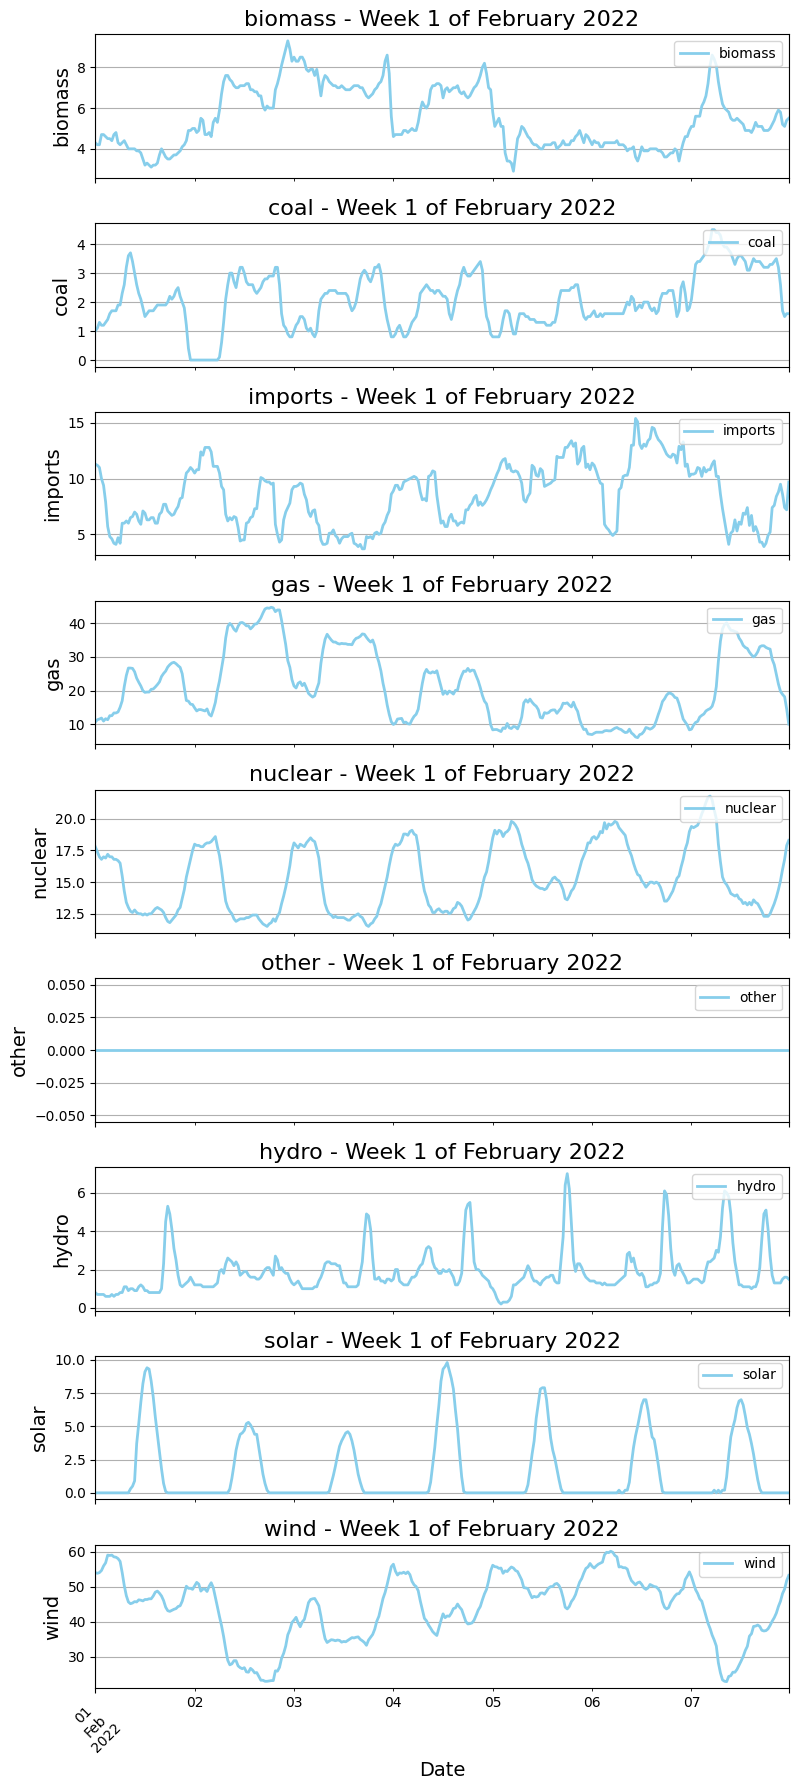

In [2]:
# Select the data for the week of February
week_data = data_df['2022-02-01':'2022-02-07']

# Set up subplots
fig, axs = plt.subplots(len(week_data.columns), 1, figsize=(8, 2 * len(week_data.columns)), sharex=True)

# Plot each feature in a separate subplot
for ax, col in zip(axs, week_data.columns):
    week_data[col].plot(ax=ax, color='skyblue', linewidth=2)
    ax.set_title(f'{col} - Week 1 of February 2022', fontsize=16)
    ax.set_ylabel(col, fontsize=14)
    ax.grid(True)
    ax.legend([col], loc='upper right')

plt.xlabel("Date", fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


We can notice again daily seasonality for fossil fuel usage. 

- Its great to see that the main energy produced is coming from wind farms this week. However the second most used fuel is gas. This is neccessary to meet energy demands and to hold the grid in case of changing weather. 

- The other column is empty and best to drop it now as a useless dimension. 

In [3]:
def create_date_features(df: pd.DataFrame) -> pd.DataFrame:
   """Create time-based features from datetime index."""
   df = df.copy()
   
   # Extract temporal features
   df['minute'] = df.index.minute
   df['hour'] = df.index.hour 
   df['dayofweek'] = df.index.dayofweek  # Monday=0, Sunday=6
   df['month'] = df.index.month
   df['is_weekend'] = df.index.dayofweek > 4  # True for Sat/Sun
   
   return df

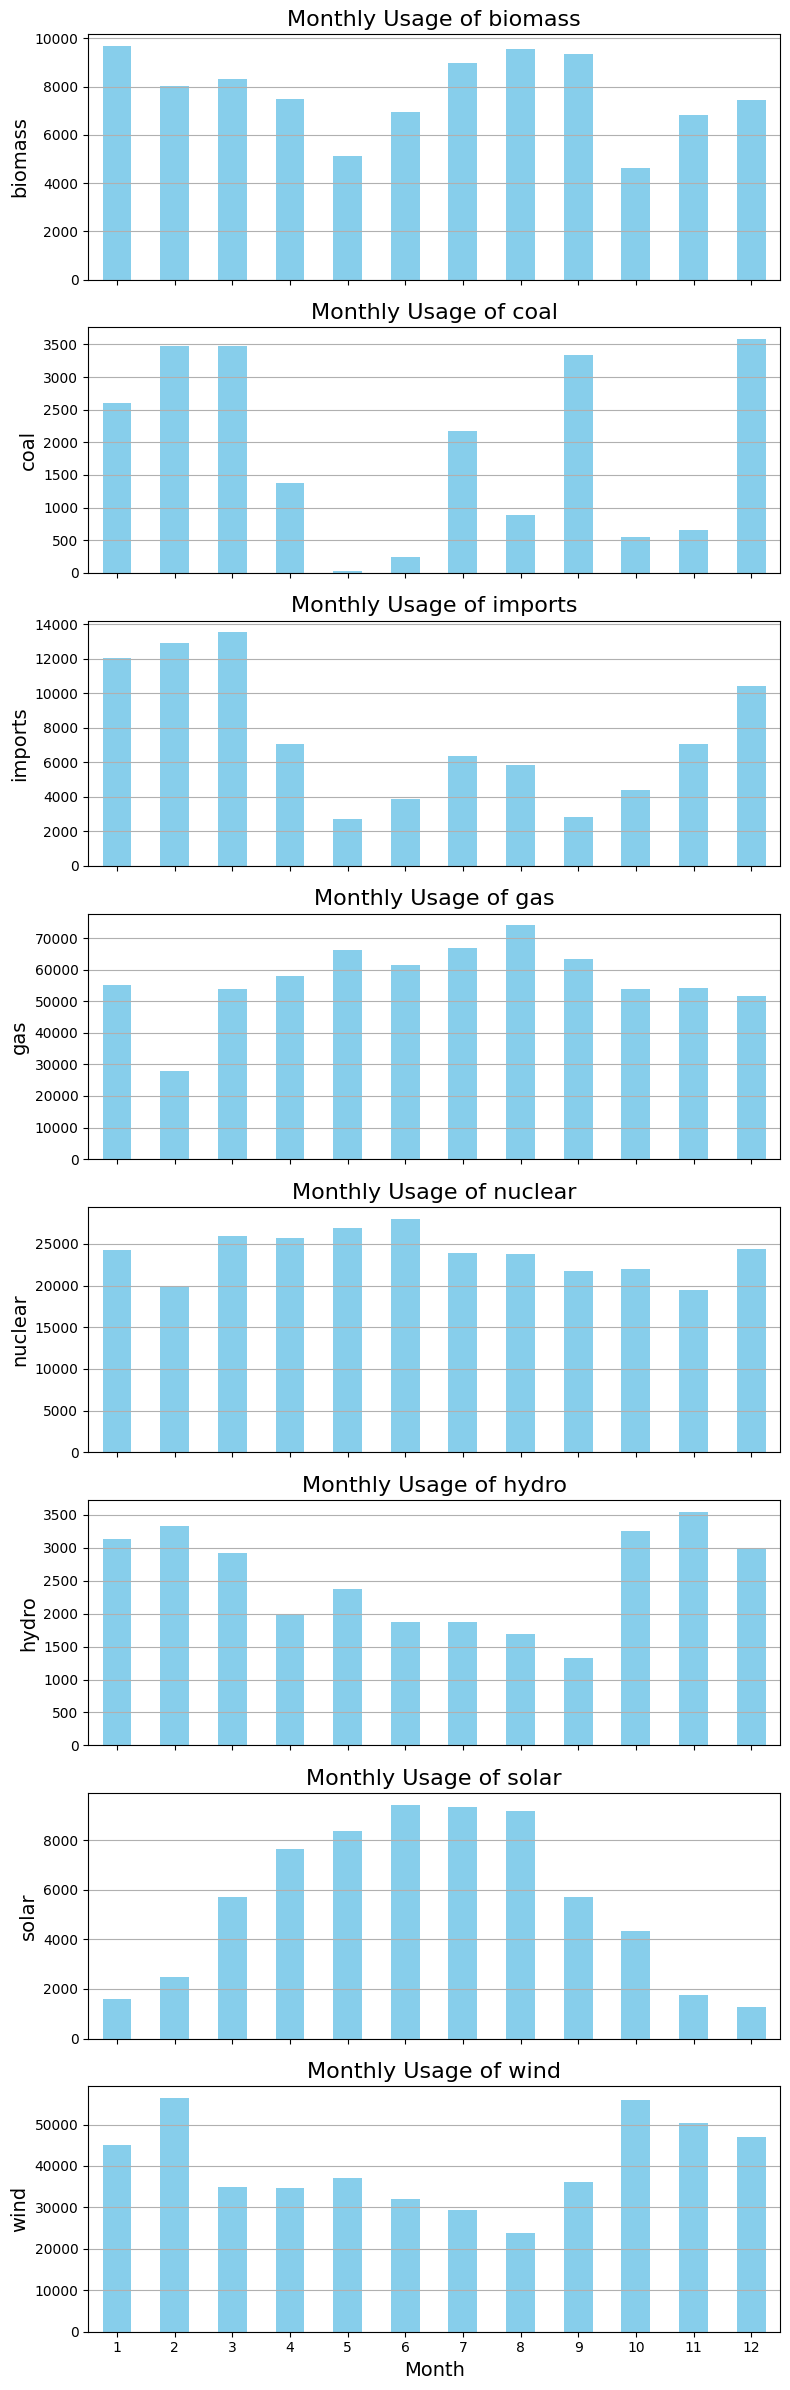

In [4]:
# Create date features and group by month to aggregate data
data_df = data_df.drop(columns=['other'])
data_df = create_date_features(data_df)
monthly_data = data_df.groupby('month').sum()

cols_to_drop = ['minute', 'hour', 'dayofweek', 'is_weekend']
monthly_data = monthly_data.drop(columns=cols_to_drop)

# Set up the plot for each column
fig, axs = plt.subplots(len(monthly_data.columns), 1, figsize=(8, 3 * len(monthly_data.columns)), sharex=True)



# Plot each column as a bar chart
for ax, col in zip(axs, monthly_data.columns):
    monthly_data.plot(kind='bar', y=col, ax=ax, legend=False, color='skyblue')
    ax.set_title(f'Monthly Usage of {col}', fontsize=16)
    ax.set_ylabel(col, fontsize=14)
    ax.set_xlabel('Month', fontsize=14)
    ax.grid(axis='y')

plt.xticks(rotation=0)  # Keep month labels horizontal
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


We can notice that Nuclear energy is constantly used in the UK for energy supply, as well as gas. The other fossil fuels are used interchangeably. 

- Also the other column is always empty, best to remove it as a useless dimension. 


# Great looking forward to using these extra features